In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import datasets
from tqdm import notebook

(1000, 5) (1000,)


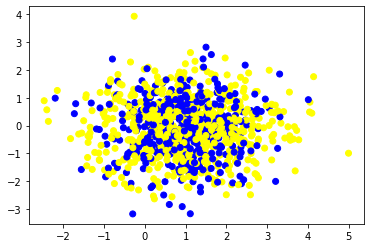

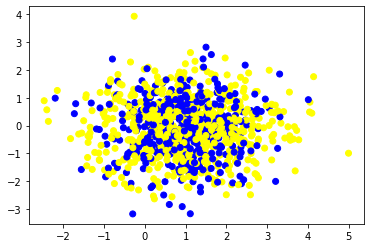

(750, 5) (250, 5)


In [25]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","green","blue"])

#Generating 1000 observations with 4 labels - multi class
data, labels =  datasets.make_classification(n_samples=1000, n_features=5, n_classes=2, n_redundant=0,n_clusters_per_class=1, weights=[0.5, 0.3], random_state=42)
print(data.shape, labels.shape)

#visualize the data
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

#converting the multi-class to binary 
labels_orig = labels
labels = np.mod(labels_orig, 2)
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

#split the binary data
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

In [26]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):
    #intialize the inputs
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
    
    for e in notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

  0%|          | 0/1000 [00:00<?, ?epoch/s]

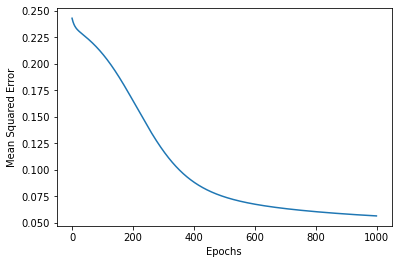

Training accuracy 0.93
Validation accuracy 0.93
mean_square_error_loss. 0.07


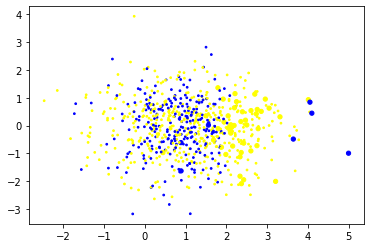

In [27]:
ffsnn = FFSNNetwork(5, [2, 3])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.001, display_loss=True)

Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)
error_loss = mean_squared_error(Y_pred_binarised_val, Y_val)
print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))
print("mean_square_error_loss.", round(error_loss, 2))

#visualize the results
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()